In [1]:
def compute_Es(T):
    '''compute the saturation vapor pressure based on air temperature'''
    
    return 0.6108*np.exp((17.27*T)/(T+237.3)) #Kpa

In [2]:
def compute_air_density(TA,PA_H2O,PA):
    '''Compute air density.
    
    IN: DataFrame Containing:
    - Air Temperature [deg. C]
    - partial pressure of water vapor [kPa]
    - air pressure [kPa]
    
    OUT:
    - density of the air [kg/m3]
    '''
    
    T = TA + 273.15 # convert to kelvin
    Pv = PA_H2O*1000. # convert kPa to Pa
    P = PA*1000. # convert kPa to Pa
    Rd = 287.5 # R/Md
    
    return (P/(Rd*T))*(1-((0.378*Pv)/P)) # density of air [kg/m3]

In [3]:
def compute_S(TA):
    '''THIS FUNCTION CALCULATES THE SLOPE OF THE 
    SATURATION VAPOUR PRESSURE VS. TEMPERATURE CURVE (BUCK, 1981 ?)[kPa/deg. C]'''
    
    return 0.61121*((17.368*238.88)/(TA+238.88)**2)*np.exp((TA*17.368)/(TA+238.88)) #kPa/deg C

In [4]:
def compute_canopy_cond(S,psy,B,g_a,rho_air,Cp_air,VPD,LE):
    '''
    Compute canopy conductance from Blanken and Black [2004].
    
    IN:
    - S [kPa/deg C]
    - psy [kpa/deg C]
    - g_a [m/s]
    - rho_air [kg/m3]
    - Cp_air [kj/kg deg. C]
    - VPD [kPa]
    - LE [W/m2]
    
    OUT:
    - g_c [m/s]
    '''
    
    LE /= 1000. # W/m2 to kj/s m2
    
    term1 = (((S/psy)*B)-1)*(1/g_a)
    term2 = ((rho_air*Cp_air)/psy)*(VPD/LE)
    
    return (term1+term2)**-1 # m/s canopy conductance

In [5]:
def compute_r_a(ustar,u):
    '''Compute aerodynamic resistance [s/m]
    IN:
    - USTAR [m/s]
    - Windspeed [m/s]
    
    OUT:
    - r_a [s/m]'''
    
    return (2.75/ustar)+(u/ustar**2)
    

In [6]:
def compute_g_c_2(r_a,NR,S,LE,G,psy,rho_air,VPD):
    '''Compute canopy conductance from Blanken [2002].
    IN:
    - ra: Aerodynamic conductance [s/m]
    - NR: Net Radiation [W/m2]
    - S: Slope of the saturated vapor pressure curve [kPa/deg. C]
    - LE: Latent heat flux [W/m2]
    - G: Ground heat flux [W/m2]
    - psy: psychrometric constant [kPa/deg.C]
    - VPD: Vapor pressure deficit [kPa/deg.C]
    
    OUT:
    - g_c: Canopy conductance [m/s]'''
    Cp_a = 1.006 # kj/kg deg. C
    
    NR /= 1000. # W/m2 > kj/s m2
    G /= 1000. # W/m2 > kj/s m2
    LE /= 1000. # W/m2 > kj/s m2
    
    return ((r_a*(S*(NR-G)-LE*(S-psy)) + rho_air*Cp_a*VPD)/(psy*LE))**-1
    

In [7]:
def compute_bowen(LE,H):
    '''Compute the Bowen Ratio (sensible heat flux / latent heat flux)'''
    
    return H/LE

In [8]:
def compute_psych_Cpa(TA,Es,PA):
    '''Computes psychrometric constant [kPa/deg. C] based on pressure [kPa].'''
    
    epsilon = 0.622
    specific_heat_dry_air = 1003 # j/deg. C
    specific_heat_water_vapour = 1810 # j/deg.C
    mixing_ratio = Es*epsilon/(PA-Es)
    specific_heat = (specific_heat_dry_air + mixing_ratio*specific_heat_water_vapour)/(1+mixing_ratio) # j/deg.C
    lamda = (2501 - 2.38*TA)*1000
    psychrometer_constant = PA*specific_heat/(epsilon*lamda) 
    
    return psychrometer_constant,specific_heat

In [9]:
def run(df):
    
    LE = df.LE.copy() # latent heat flux [W/m2]
    H = df.H.copy() # sensible heat flux [W/m2]
    PA = df.PA.copy() # Air pressure [kPa]
    TA = df.TA.copy() # air temperature [deg.C]
    
    VPD = df.VPD_PI.copy() # vapor pressure deficit [hPa]
    VPD *= 100. # hPa > Pa
    VPD /= 1000. # Pa > Kpa
    
    WS = df.WS.copy() # wind speed [m/s]
    USTAR = df.USTAR.copy() # friction velocity [m/s]
    ST = 2.75
    RH = df.RH.copy() # relative humidity [%]
    
    Es = compute_Es(TA) # Saturation vapor pressure [kPa]
    
    PA_H2O = Es*(RH/100.) # compute vater vapor pressure (Pa)
    PA_H2O /= 1000. # Pa > kPa
    
    g_b = (ST/USTAR)
    g_e = (WS/USTAR**2)
    
    rho_air = compute_air_density(TA,PA_H2O,PA)
    
    g_a = ((1/g_b)+(1/g_e))**-1
    
    S = compute_S(TA) # kPa/deg.C
    
    psy,Cpa = compute_psych_Cpa(TA,Es,PA) # kPa/deg.C and j/deg.C
    Cpa /= 1000. # j/deg.C > kj/deg.C
    
    B = compute_bowen(LE,H) # unitless
    
    g_c = compute_canopy_cond(S,psy,B,g_a,rho_air,Cpa,VPD,LE) # m/s
    
    return Es,PA_H2O,g_b,g_e,rho_air,g_a,S,psy,Cpa,B,g_c

In [10]:
def run2(df):
    
    NR = df.NETRAD.copy() # net radiation [W/m2]
    LE = df.LE.copy() # latent heat flux [W/m2]
    PA = df.PA.copy() # Air pressure [kPa]
    TA = df.TA.copy() # air temperature [deg.C]
    H = df.H.copy()
    
    VPD = df.VPD_PI.copy() # vapor pressure deficit [hPa]
    VPD *= 100. # hPa > Pa
    VPD /= 1000. # Pa > Kpa
    
    WS = df.WS.copy() # wind speed [m/s]
    USTAR = df.USTAR.copy() # friction velocity [m/s]
    RH = df.RH.copy() # relative humidity [%]
    
    Es = compute_Es(TA) # Saturation vapor pressure [kPa]
    
    PA_H2O = Es*(RH/100.) # compute vater vapor pressure (Pa)
    PA_H2O /= 1000. # Pa > kPa
        
    rho_air = compute_air_density(TA,PA_H2O,PA)
        
    S = compute_S(TA) # kPa/deg.C
    
    psy,Cpa = compute_psych_Cpa(TA,Es,PA) # kPa/deg.C and j/deg.C

    r_a = compute_r_a(USTAR,WS)
    
    G = NR-H-LE
    
    g_c = compute_g_c_2(r_a,NR,S,LE,G,psy,rho_air,VPD)
    
    return Es,PA_H2O,r_a,rho_air,S,psy,g_c

In [11]:
def make_dt(dt):
    dt = str(dt)

    YYYY = dt[0:4]
    MM = dt[4:6]
    DD = dt[6:8]
    HH = dt[8:10]
    mm = dt[10:12]

    return '%s-%s-%s %s:%s'%(YYYY,MM,DD,HH,mm)
    

In [12]:
dat = pd.read_csv('./data/AMF_US-Vcm_BASE-BADM_4-1/AMF_US-Vcm_BASE_HH_4-1.csv', skiprows=2,na_values=-9999)

In [13]:
vars = ['NETRAD','LE','H','VPD_PI','WS','USTAR','TA','RH','PA','TIMESTAMP_START','SW_IN','NEE_PI']

In [14]:
dat = dat[vars].copy()

In [15]:
dat.index = pd.DatetimeIndex(dat.TIMESTAMP_START.map(make_dt))

In [16]:
dat.dropna(inplace=True)

In [17]:
dat['idx'] = dat.index

In [18]:
tmp = pd.DataFrame(pd.read_pickle('./data/VCM_half_hour.pcl')['GPP'])
tmp['idx'] = tmp.index

In [19]:
dat = pd.merge(left=dat,right=tmp,how='inner',on='idx')

In [20]:
dat.index = pd.DatetimeIndex(dat.idx)
del dat['idx']

In [21]:
Es,PA_H2O,r_a,rho_air,S,psy,g_c = run2(dat)

In [22]:
dat['Es'] = Es
dat['PA_H2O'] = PA_H2O
dat['rho_air'] = rho_air
dat['S'] = S
dat['psy'] = psy
dat['g_c'] = g_c

In [23]:
round(dat.g_c.median(),3)

0.012

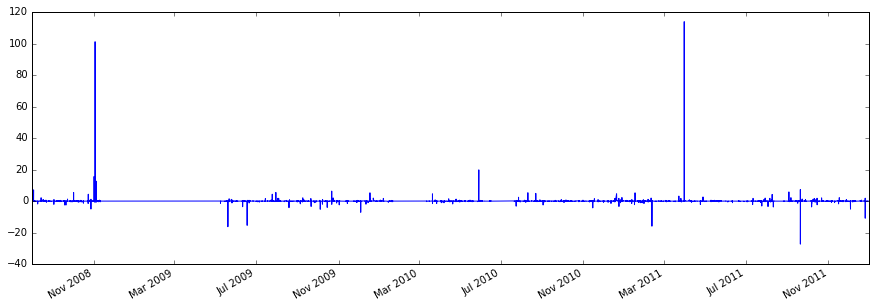

In [24]:
plt.figure(figsize=(15,5))
dat.g_c.plot()
#plt.ylim(0,10)

In [25]:
# remove night time obs
dat.loc[dat.SW_IN<5] = np.NaN
dat.loc[dat.g_c<0] = np.NaN

In [26]:
dat.dropna(inplace=True)

In [27]:
len(dat)

15247

In [28]:
import statsmodels.api as sm

In [29]:
mod = sm.formula.ols('LE ~ GPP + 1',dat).fit()

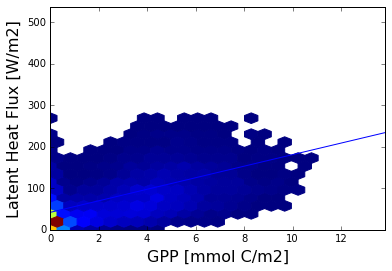

In [30]:
x = np.linspace(dat.GPP.min(),dat.GPP.max(),100)
y = x*mod.params['GPP']+mod.params['Intercept']
plt.hexbin(dat.GPP,dat.LE,mincnt=10,gridsize=25)
plt.plot(x,y,'-')
plt.ylabel('Latent Heat Flux [W/m2]',fontsize=16)
plt.xlabel('GPP [mmol C/m2]',fontsize=16)

In [31]:
LEmin = 150
LEmax = 200
gppmin=8
gppmax=10

In [32]:
dat2 = dat.loc[(dat.LE>LEmin)&(dat.LE<LEmax)&(dat.GPP>gppmin)&(dat.GPP<gppmax)].copy()

In [33]:
dat2.loc[dat.g_c>0.045,'g_c'] = np.NaN

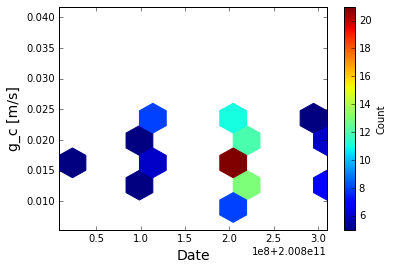

In [35]:
plt.hexbin(dat2.TIMESTAMP_START,dat2.g_c,mincnt=5,gridsize=10)
plt.colorbar(label='Count')
plt.xlabel('Date', fontsize=14)
plt.ylabel('g_c [m/s]', fontsize=14)

In [155]:
def mmol2m(g_c,LAI):
    '''convert g_c in mmmol/m2 s to m/s'''
    molarmassH2O = 18.01528 # g/mol
    g_c *= 0.001 # mmol to mol/m s
    g_c *= LAI # convert from m2 of leaf area to m2 of ground area
    g_c *= molarmassH2O # mol to grams also ml 
    g_c /= 1000. # g > kg
    g_c /= 0.804 # kg water vapor to m3 of water vapor

    # assume this is for 1 m2 of ground so m3 becomes m
    
    return g_c

In [156]:
mmol2m(300,3.5)

0.023527417910447764